# Skincare Recommender Using Supervised Learning and NLP
When it comes to selecting skincare products, we often face an overwhelming amount of choices. While reviews can be helpful, some of them can often be biased or ambiguous, leaving us more confused than ever. To address the overwhelming amount of choices and biases in skincare products, this project will build skincare product recommendation system that evaluates sentiment across product reviews and predicts recommendation likelihood and popularity based on those sentiments.

Dataset used: https://www.kaggle.com/datasets/melissamonfared/sephora-skincare-reviews

The following ML approaches will be used:
* Natural Language Processing and Supervised Machine Learning
    * Sentiment analysis - Using the pretrained transformer RoBERTa, the model extracted sentiment from review text and assigned numeric labels: label_0 (negative), label_1 (neutral), and label_2 (positive)
    * Recommendation target - Combined is_recommended and sentiment to build a clean binary target for classification model. Originally, the feature is_recommended (where users select whether they recommend a product or not) was used, but it became clear that the model was overfitting since the data was very skewed (majority of the products were labeled as "recommended" despite negative sentiment). As a result, reco_clean was created by combining is_recommended and sentiment score. Because of the data imbalance, SMOTE (Synthetic Minority Over-sampling Technique) was applied before training to address this issue
    * Feature engineering - Aggregated product-level features including average sentiment, mean rating, review volume, product category, and user skin type were used
    * Modeling - The following models were tested:
        * For classification models, Logistic Regression, Random Forest, and XGBoost were all tested to see which one predicted whether a product was most likely to be recommended based on both the recommendation label and sentiment
        * For regression models, Ridge, Random Forest, and XGBoost were all tested to predict the overall product popularity
    * Model selection - After cross-validating, XGBoost Classifier and Random Forest Regressor were selected as the top-performing models based on the AUC, RMSE, and R² scores

Result Summary
* Using XGBoost Classifier and Random Forest Regressor, a ranked list of top 10 products were created combining the predicted recommendation probability, the predicted probability and the scaled unified score. Ratings by skin types, sentiment by product, and precision and recall of the recommender were visualized. By evaluating sentiment from product reviews, this model predicts the likelihood and popularity of a product, offering optimal recommendations.

The project is divided into the following parts
* Data Preprocessing and Cleaning
* Model Building and Testing
* Model Evaluation and Training

## Data Preprocessing and Cleaning

In [53]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import re 
import torch
import xgboost as xgb
from math import sqrt
from transformers import pipeline
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import accuracy_score, make_scorer, roc_auc_score, mean_squared_error, r2_score, classification_report
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

In [124]:
product_info = pd.read_csv('sephora_data/product_info_skincare.csv', dtype={'rating': float})
product_info['rating'] = product_info['rating'].astype(float).round(4)
product_info.columns = product_info.columns.str.strip().str.lower().str.replace(' ', '_')

review_files = [
    'sephora_data/reviews_0-250_masked.csv',
    'sephora_data/reviews_250-500_masked.csv',
    'sephora_data/reviews_500-750_masked.csv',
    'sephora_data/reviews_750-1250_masked.csv',
    'sephora_data/reviews_1250-end_masked.csv',
]

review_dfs = []
for f in review_files:
    df = pd.read_csv(f)
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    review_dfs.append(df)

all_reviews = pd.concat(review_dfs, ignore_index=True)
all_reviews = all_reviews.drop(columns=['rating', 'price_usd'], errors='ignore')

if 'product_id' in all_reviews.columns and 'product_id' in product_info.columns:
    skincare_reviews = all_reviews[all_reviews['product_id'].isin(product_info['product_id'])]
else:
    raise KeyError("Column 'product_id' not found in both datasets.")


skincare_reviews = all_reviews.merge(
    product_info,
    how='left',
    on='product_id',
    suffixes=('', '_product')
)

skincare_reviews['sentiment'] = pd.NA

desired_order = ['product_id', 'product_name', 'brand_id', 'brand_name', 'rating', 'is_recommended', 'price_usd', 'primary_category', 'secondary_category', 'tertiary_category', 'variation_type', 'variation_value', 'highlights', 'review_title', 'sentiment', 'review_text', 'ingredients', 'skin_type']

for col in desired_order:
    if col not in skincare_reviews.columns:
        skincare_reviews[col] = np.nan

skincare_reviews = skincare_reviews[desired_order]
skincare_reviews.head(5)

,product_id,product_name,brand_id,brand_name,rating,is_recommended,price_usd,primary_category,secondary_category,tertiary_category,variation_type,variation_value,highlights,review_title,sentiment,review_text,ingredients,skin_type
0,P504322,Gentle Hydra-Gel Face Cleanser,7055,NUDESTIX,5.0000,1.0,19.0,Skincare,Cleansers,NaN,Size,2.4 oz / 70 ml,['Clean at Sephora'],Taught me how to double cleanse!,<NA>,I use this with the Nudestix “Citrus Clean Bal...,"['Water (Aqua), Dipropylene Glycol, Peg-6 Capr...",dry
1,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,6125,LANEIGE,4.3508,0.0,24.0,Skincare,Lip Balms & Treatments,NaN,Color,Original,"['allure 2019 Best of Beauty Award Winner', 'C...",Disappointed,<NA>,I bought this lip mask after reading the revie...,"['Diisostearyl Malate, Hydrogenated Polyisobut...",NaN
2,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,6125,LANEIGE,4.3508,1.0,24.0,Skincare,Lip Balms & Treatments,NaN,Color,Original,"['allure 2019 Best of Beauty Award Winner', 'C...",New Favorite Routine,<NA>,My review title says it all! I get so excited ...,"['Diisostearyl Malate, Hydrogenated Polyisobut...",dry
3,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,6125,LANEIGE,4.3508,1.0,24.0,Skincare,Lip Balms & Treatments,NaN,Color,Original,"['allure 2019 Best of Beauty Award Winner', 'C...",Can't go wrong with any of them,<NA>,I’ve always loved this formula for a long time...,"['Diisostearyl Malate, Hydrogenated Polyisobut...",combination
4,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,6125,LANEIGE,4.3508,1.0,24.0,Skincare,Lip Balms & Treatments,NaN,Color,Original,"['allure 2019 Best of Beauty Award Winner', 'C...",A must have !!!,<NA>,"If you have dry cracked lips, this is a must h...","['Diisostearyl Malate, Hydrogenated Polyisobut...",combination


In [3]:
print(skincare_reviews['product_id'].isna().sum())  # Should be 0
print(skincare_reviews['product_id'].nunique())     # Expect many, but no NaN

0
541


In [4]:
# Fill any missing columns
fillable_columns = ['rating', 'is_recommended', 'price_usd', 'primary_category', 'secondary_category', 'tertiary_category', 'variation_type', 'variation_value', 'highlights', 'review_title', 'review_text', 'ingredients', 'skin_type']

for col in fillable_columns:
    if col in skincare_reviews.columns:
        skincare_reviews[col] = (skincare_reviews.groupby('product_id')[col].transform(lambda x: x.ffill().bfill()))
    else:
        print(f"Column '{col}' not found in dataset")

for col in fillable_columns:
    print(f"{col}: {skincare_reviews[col].isna().sum()} missing values remaining")

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_1222/3273220989.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  skincare_reviews[col] = (skincare_reviews.groupby('product_id')[col].transform(lambda x: x.ffill().bfill()))
/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_1222/3273220989.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  skincare_reviews[col] = (skincare_reviews.groupby('product_id')[col].transform(lambda x: x.ffill().bfill()))
/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_1222/3273220989.py:6: FutureW

rating: 0 missing values remaining
is_recommended: 0 missing values remaining
price_usd: 0 missing values remaining
primary_category: 0 missing values remaining
secondary_category: 0 missing values remaining
tertiary_category: 54104 missing values remaining
variation_type: 8721 missing values remaining
variation_value: 10728 missing values remaining
highlights: 22004 missing values remaining
review_title: 2 missing values remaining
review_text: 0 missing values remaining
ingredients: 3731 missing values remaining
skin_type: 1 missing values remaining


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_1222/3273220989.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  skincare_reviews[col] = (skincare_reviews.groupby('product_id')[col].transform(lambda x: x.ffill().bfill()))


In [125]:
fillable_columns = ['rating', 'is_recommended', 'price_usd', 'primary_category', 'secondary_category', 'tertiary_category', 'variation_type', 'variation_value', 'highlights', 'review_title', 'review_text', 'ingredients', 'skin_type']  

products_with_missing = (
    skincare_reviews.groupby('product_id')[fillable_columns]
    .apply(lambda df: df.isna().any().any())  
)

valid_product_ids = products_with_missing[products_with_missing == False].index
skincare_reviews_clean = skincare_reviews[skincare_reviews['product_id'].isin(valid_product_ids)].copy()

skincare_reviews_clean.head(5)

,product_id,product_name,brand_id,brand_name,rating,is_recommended,price_usd,primary_category,secondary_category,tertiary_category,variation_type,variation_value,highlights,review_title,sentiment,review_text,ingredients,skin_type
285132,P503935,Volcanic Pore Clearing Facial Cleanser with AH...,6295,innisfree,4.4444,1.0,14.0,Skincare,Cleansers,Face Wash & Cleansers,Size,5 oz / 150 mL,"['Good for: Pores', 'Without Mineral Oil', 'AH...",Perfection,<NA>,This is my favorite cleanser. It’s the perfect...,"['Water / Aqua / Eau, Glycerin, Myristic Acid,...",dry
285133,P503935,Volcanic Pore Clearing Facial Cleanser with AH...,6295,innisfree,4.4444,1.0,14.0,Skincare,Cleansers,Face Wash & Cleansers,Size,5 oz / 150 mL,"['Good for: Pores', 'Without Mineral Oil', 'AH...",Litiwallyfiree,<NA>,This stuff is GOOD. It doesn’t dry out my skin...,"['Water / Aqua / Eau, Glycerin, Myristic Acid,...",combination
285134,P503935,Volcanic Pore Clearing Facial Cleanser with AH...,6295,innisfree,4.4444,1.0,14.0,Skincare,Cleansers,Face Wash & Cleansers,Size,5 oz / 150 mL,"['Good for: Pores', 'Without Mineral Oil', 'AH...",It's nice just fragrant.,<NA>,"Fragrant with musky scent.Foams very well, nic...","['Water / Aqua / Eau, Glycerin, Myristic Acid,...",combination
285135,P503935,Volcanic Pore Clearing Facial Cleanser with AH...,6295,innisfree,4.4444,1.0,14.0,Skincare,Cleansers,Face Wash & Cleansers,Size,5 oz / 150 mL,"['Good for: Pores', 'Without Mineral Oil', 'AH...",Works!,<NA>,I’ve been using this product for a week! I def...,"['Water / Aqua / Eau, Glycerin, Myristic Acid,...",combination
285136,P503935,Volcanic Pore Clearing Facial Cleanser with AH...,6295,innisfree,4.4444,1.0,14.0,Skincare,Cleansers,Face Wash & Cleansers,Size,5 oz / 150 mL,"['Good for: Pores', 'Without Mineral Oil', 'AH...",Easily new favourite!,<NA>,I was using YTP Superfood Cleanser for the lon...,"['Water / Aqua / Eau, Glycerin, Myristic Acid,...",combination


Sentiment Analysis
* We will use Cardiff NLP model to analyze the sentiments across the reviews
* For the sake of speed and memory, we will do batched anaylsis

In [6]:
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    device=-1  # CPU
)

def safe_batched_sentiment(texts, batch_size=8):
    results = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = [str(t)[:256] for t in texts[i:i+batch_size]]
        try:
            batch_results = sentiment_pipeline(batch, truncation=True)
            results.extend([r['label'].lower() for r in batch_results])
        except Exception as e:
            print(f"Batch {i} failed: {e}")
            results.extend(['neutral'] * len(batch))
    return results

Device set to use cpu


In [7]:
# Run and save it as CSV since it's very slow (takes 2 hours)

subset = skincare_reviews_clean['sentiment'].isna()
skincare_reviews_clean.loc[subset, 'sentiment'] = safe_batched_sentiment(
    skincare_reviews_clean.loc[subset, 'review_text'].fillna('').tolist()
)

 96%|█████████▌| 24229/25182 [2:04:43<05:06,  3.11it/s]  

Batch 193832 failed: The expanded size of the tensor (573) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 573].  Tensor sizes: [1, 514]


100%|██████████| 25182/25182 [2:09:37<00:00,  3.24it/s]


In [9]:
skincare_reviews_clean.to_csv("clean_data/skincare_reviews_clean.csv", index=False)

In [8]:
# Get average sentiment per product, taking into consideration the number of reviews
df_skincare_reviews_clean = pd.read_csv("clean_data/skincare_reviews_clean.csv")
sentiment_map = {
    'label_2': 1,
    'label_1': 0,
    'label_0': -1
}
df_skincare_reviews_clean['sentiment_score'] = df_skincare_reviews_clean['sentiment'].map(sentiment_map)

avg_sentiment = (
    df_skincare_reviews_clean.groupby('product_id')['sentiment_score']
    .mean()
    .reset_index()
    .rename(columns={'sentiment_score': 'avg_sentiment_score'})
)

review_counts = (
    df_skincare_reviews_clean.groupby('product_id')
    .size()
    .reset_index(name='review_count')
)

sentiment_weighted = avg_sentiment.merge(review_counts, on='product_id')

C = sentiment_weighted['avg_sentiment_score'].mean()
m = sentiment_weighted['review_count'].quantile(0.50)

sentiment_weighted['weighted_sentiment_score'] = (
    (sentiment_weighted['review_count'] * sentiment_weighted['avg_sentiment_score'] + m * C) /
    (sentiment_weighted['review_count'] + m)
)

product_meta = df_skincare_reviews_clean[['product_id', 'product_name', 'brand_name', 'price_usd']].drop_duplicates()

sentiment_ranking = sentiment_weighted.merge(product_meta, on='product_id')
sentiment_ranking = sentiment_ranking.sort_values(by='weighted_sentiment_score', ascending=False)
sentiment_ranking.head(10)

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_1946/1348605897.py:2: DtypeWarning: Columns (0,1,2,3,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_skincare_reviews_clean = pd.read_csv("clean_data/skincare_reviews_clean.csv")


,product_id,avg_sentiment_score,review_count,weighted_sentiment_score,product_name,brand_name,price_usd
157,P386197,0.993364,33606,0.992793,GinZing Refreshing Scrub Cleanser,Origins,27.0
174,P406104,0.984498,12063,0.982956,24K Gold Pure Luxury Lift & Firm Hydra-Gel Eye...,Peter Thomas Roth,75.0
177,P409631,0.949603,3274,0.944649,SEA FRXXXTION Stick Exfoliating Cleanser,tarte,22.0
477,P505023,0.964639,707,0.941934,The POREfessional Deep Retreat Pore-Clearing C...,Benefit Cosmetics,39.0
390,P479841,0.943262,1128,0.929704,Floral Recovery Overnight Mask with Squalane,fresh,69.0
479,P505054,0.942675,471,0.912472,The POREfessional Speedy Smooth Mask,Benefit Cosmetics,39.0
463,P504042,0.937158,366,0.900345,Ceramidin Skin Barrier Moisturizing Mask,Dr. Jart+,9.0
468,P504421,0.940000,300,0.895988,Overnight Hydrating Mask,SEPHORA COLLECTION,16.0
364,P474822,0.921569,357,0.886271,Daily Glycolic Cleanser,Dermalogica,37.0
442,P501171,0.909091,484,0.883420,YUZU-C Beauty Sleeping Mask,WASO,38.0


User Profile
* Skin type
* Skin treatment 
* Budget

In [9]:
# List out all the skin types and category info
skin_types = sorted(df_skincare_reviews_clean['skin_type'].dropna().str.lower().unique())

primary_categories = sorted(df_skincare_reviews_clean['primary_category'].dropna().unique())
secondary_categories = sorted(df_skincare_reviews_clean['secondary_category'].dropna().unique())
tertiary_categories = sorted(df_skincare_reviews_clean['tertiary_category'].dropna().unique())

print("Skin Types:")
print(skin_types)
print("\nPrimary Categories:")
print(primary_categories)
print("\nSecondary Categories:")
print(secondary_categories)
print("\nTertiary Categories:")
print(tertiary_categories)

Skin Types:
['combination', 'dry', 'normal', 'oily']

Primary Categories:
['Skincare']

Secondary Categories:
['Cleansers', 'Eye Care', 'Masks', 'Moisturizers', 'Self Tanners', 'Sunscreen', 'Treatments']

Tertiary Categories:
['BB & CC Creams', 'Blemish & Acne Treatments', 'Decollete & Neck Creams', 'Exfoliators', 'Eye Creams & Treatments', 'Eye Masks', 'Face Masks', 'Face Oils', 'Face Serums', 'Face Sunscreen', 'Face Wash & Cleansers', 'Facial Peels', 'For Body', 'Makeup Removers', 'Moisturizers', 'Night Creams', 'Sheet Masks', 'Toners']


In [10]:
# Category mapping
category_mapping = {
    'cleansers': ['face wash & cleansers', 'makeup removers', 'exfoliators'],
    'eye care': ['eye creams & treatments', 'eye masks'],
    'masks': ['face masks', 'sheet masks'],
    'moisturizers': ['moisturizers', 'night creams', 'face serums', 'decollete & neck creams', 'toners', 'face oils', 'for body'],
    'self tanners': ['for body'],
    'sunscreen': ['face sunscreen'],
    'treatments': ['face serums', 'facial peels', 'blemish & acne treatments', 'exfoliators', 'bb & cc creams', 'decollete & neck creams', 'toners', 'face oils']
}

df_skincare_reviews_clean['skin_type'] = df_skincare_reviews_clean['skin_type'].str.lower()
df_skincare_reviews_clean['secondary_category'] = df_skincare_reviews_clean['secondary_category'].str.lower()
df_skincare_reviews_clean['tertiary_category'] = df_skincare_reviews_clean['tertiary_category'].str.lower()
df_skincare_reviews_clean['highlights'] = df_skincare_reviews_clean['highlights'].astype(str).str.lower()

user_skin_type = 'dry'
user_secondary = 'moisturizers'
valid_tertiaries = category_mapping.get(user_secondary.lower(), [])

filtered_df = df_skincare_reviews_clean[df_skincare_reviews_clean['skin_type'] == user_skin_type] 
filtered_df = filtered_df[
    filtered_df['secondary_category'].str.contains(user_secondary, case=False, na=False) &
    filtered_df['tertiary_category'].isin(valid_tertiaries)
]

filtered_df = filtered_df[
    filtered_df['highlights'].str.contains(user_skin_type, na=False)
]

# Only display products with a minimum of 10 reviews
min_reviews = 10
valid_products = (
    filtered_df['product_id']
    .value_counts()
    .loc[lambda x: x >= min_reviews]
    .index
)
filtered_df = filtered_df[filtered_df['product_id'].isin(valid_products)]

filtered_df[['product_id', 'product_name', 'brand_name', 'skin_type', 'secondary_category', 'tertiary_category']].drop_duplicates().head(10)

,product_id,product_name,brand_name,skin_type,secondary_category,tertiary_category
8759,P248407,Ultra Repair Cream Intense Hydration,First Aid Beauty,dry,moisturizers,moisturizers
52870,P430337,C-Rush Vitamin C Gel Moisturizer,OLEHENRIKSEN,dry,moisturizers,moisturizers
78079,P433887,Squalane + Omega Repair Deep Hydration Moistur...,Biossance,dry,moisturizers,moisturizers
174776,P422430,Hydra Zen Gel-Cream Oil-Free Moisturizer with ...,Lancôme,dry,moisturizers,moisturizers
189250,P375534,Ultra Repair Face Moisturizer,First Aid Beauty,dry,moisturizers,moisturizers
209173,P481739,Barrier+ Skin Barrier Niacinamide Restoring Ge...,Skinfix,dry,moisturizers,moisturizers
211425,P505031,The POREfessional Smooth Sip Lightweight Gel-C...,Benefit Cosmetics,dry,moisturizers,moisturizers
213579,P416561,Squalane + Probiotic Balancing Gel Moisturizer,Biossance,dry,moisturizers,moisturizers
218335,P466153,Cloud Dew Gel Cream Moisturizer,Summer Fridays,dry,moisturizers,moisturizers
219035,P479125,Mini Cloud Dew Oil-Free Gel Cream,Summer Fridays,dry,moisturizers,moisturizers


Create Ranking System
* Build a composite scoring function using PCA (Principal Component Analysis) instead of relying on a single metric
    * This composite score, called pca_score, will help create a balanced recommendation that takes into account popularity, user appeal, affordability, and credibility
* For the composite score, we'll measure four metrics that have influence over its quality and user appeal:
    * rating (user-based)
    * avg_sentiment_score (RoBERTa-based)
    * review_volume (number of reviews)
    * price_usd (product price)
* Merge review and product metadata
    * Handle missing values with SimpleImputer (mean)
    * Normalize all metrics using the MinMaxScaler
* PCA will help convert the four metrics into a single dimension, the pca_score

In [127]:
# Merge review and sentiment data
avg_sentiment = (
    df_skincare_reviews_clean.groupby('product_id')['sentiment']
    .apply(lambda x: x.map({'label_2': 1, 'label_1': 0, 'label_0': -1}).mean())
    .reset_index(name='avg_sentiment_score')
)

meta = df_skincare_reviews_clean[['product_id', 'product_name', 'brand_name', 'price_usd', 'rating']].drop_duplicates()
volume = df_skincare_reviews_clean['product_id'].value_counts().reset_index()
volume.columns = ['product_id', 'review_volume']

product_scores = meta.merge(avg_sentiment, on='product_id').merge(volume, on='product_id')

# PCA
features = product_scores[['rating', 'avg_sentiment_score', 'review_volume', 'price_usd']].copy()
imputer = SimpleImputer(strategy='mean') # Handle missing values
features_imputed = imputer.fit_transform(features)

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features_imputed)
pca = PCA(n_components=1)
product_scores['pca_score'] = pca.fit_transform(features_scaled)

top_recommendations = product_scores.sort_values(by='pca_score', ascending=False).head(10)
top_recommendations[['product_name', 'brand_name', 'price_usd', 'rating', 'avg_sentiment_score', 'review_volume', 'pca_score']]
weights = pca.components_[0]

for feature, weight in zip(features, weights):
    print(f"{feature:20s}: {weight:.4f}")

rating              : 0.7207
avg_sentiment_score : 0.6880
review_volume       : 0.0310
price_usd           : -0.0788


* Rating and sentiment are the biggest drivers of the score
* Review volumen does not have much effect
* Price has negative influence (expensive prices can reduce the score marginally)

In [128]:
top_recommendations.head(5)

,product_id,product_name,brand_name,price_usd,rating,avg_sentiment_score,review_volume,pca_score
352,P504417,Acne Treatment Gel,SEPHORA COLLECTION,20.0,5.0,1.0,1,0.245298
313,P505316,Aquarius BHA + Blue Tansy Clarity Cleanser,Herbivore,26.0,5.0,1.0,55,0.243753
355,P505174,Soft Clean Moisture Rich Foaming Cleanser,Estée Lauder,26.0,5.0,1.0,1,0.243703
351,P503915,Mini Floral Recovery Overnight Mask with Squalane,fresh,28.0,5.0,1.0,3,0.243174
356,P476571,Turbo Body Lotion Energizing Gel Moisturizer w...,Jack Black,38.0,5.0,1.0,1,0.240515


In [37]:
product_scores.to_csv("clean_data/product_scores.csv", index=False)

## Model Building and Testing
* For the recommender, two types of models will be tested:
    * Regression using PCA score
    * Classification using the is_recommended or another metric
* Use single train-test split and cross-validation to see model's performance

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_1946/3652430822.py:4: DtypeWarning: Columns (0,1,2,3,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_reviews = pd.read_csv("clean_data/skincare_reviews_clean.csv")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:39:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


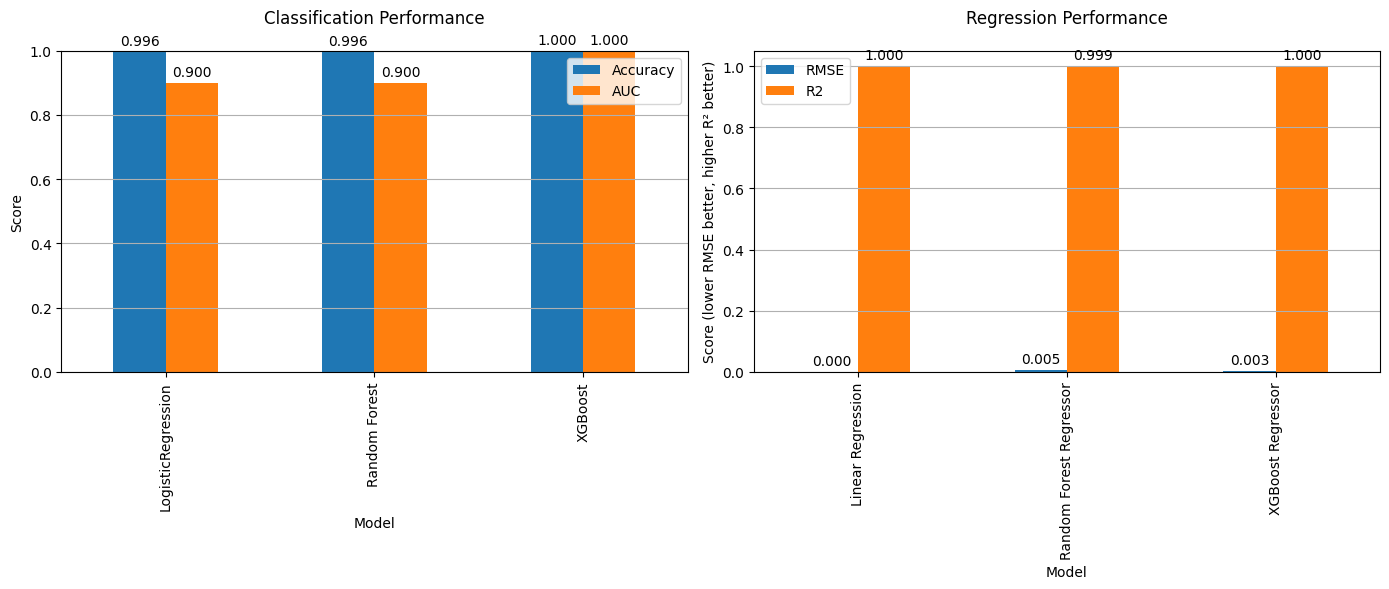

In [78]:
# Regression and Classification Model Testing Using Single Train-Test Split

df_reviews = pd.read_csv("clean_data/skincare_reviews_clean.csv")
sentiment_map = {'label_2': 1, 'label_1': 0, 'label_0': -1}
df_reviews['sentiment_score'] = df_reviews['sentiment'].map(sentiment_map)

avg_sentiment = df_reviews.groupby('product_id')['sentiment_score'].mean().reset_index(name='avg_sentiment_score')
review_volume = df_reviews['product_id'].value_counts().reset_index()
review_volume.columns = ['product_id', 'review_volume']

meta = df_reviews[['product_id', 'product_name', 'brand_name', 'price_usd', 'rating']].drop_duplicates()
metadata = df_reviews[['product_id', 'secondary_category', 'tertiary_category', 'skin_type']].drop_duplicates()

product_scores = meta.merge(avg_sentiment, on='product_id') \
                     .merge(review_volume, on='product_id') \
                     .merge(metadata, on='product_id')

features_for_pca = ['rating', 'avg_sentiment_score', 'review_volume', 'price_usd']

imputer = SimpleImputer(strategy='mean')
imputed_values = imputer.fit_transform(product_scores[features_for_pca])

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(imputed_values)

pca = PCA(n_components=1)
product_scores['pca_score'] = pca.fit_transform(scaled_values)

df_reviews['is_recommended'] = pd.to_numeric(df_reviews['is_recommended'], errors='coerce')
recommendation_rate = df_reviews.groupby('product_id')['is_recommended'].mean().reset_index()
recommendation_rate['is_recommended'] = (recommendation_rate['is_recommended'] > 0.5).astype(int)
product_scores = product_scores.merge(recommendation_rate, on='product_id', how='inner')

# Preprocess
features = ['rating', 'avg_sentiment_score', 'review_volume', 'price_usd',
            'secondary_category', 'tertiary_category', 'skin_type']
product_scores = product_scores.dropna(subset=features + ['pca_score', 'is_recommended'])

numeric_features = ['rating', 'avg_sentiment_score', 'review_volume', 'price_usd']
categorical_features = ['secondary_category', 'tertiary_category', 'skin_type']

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')),
                      ('scaler', StandardScaler())]), numeric_features),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                      ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
])

# Classification
clf_models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

X_clf = product_scores[features]
y_clf = product_scores['is_recommended'].astype(int)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

clf_results = []
for name, model in clf_models.items():
    pipe = Pipeline([('preprocess', preprocessor), ('model', model)])
    pipe.fit(X_train_clf, y_train_clf)
    preds = pipe.predict(X_test_clf)
    acc = accuracy_score(y_test_clf, preds)
    auc = roc_auc_score(y_test_clf, preds)
    clf_results.append({'Model': name, 'Accuracy': acc, 'AUC': auc})

# Regression
reg_models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBoost Regressor": XGBRegressor()
}

X_reg = product_scores[features]
y_reg = product_scores['pca_score']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

reg_results = []
for name, model in reg_models.items():
    pipe = Pipeline([('preprocess', preprocessor), ('model', model)])
    pipe.fit(X_train_reg, y_train_reg)
    preds = pipe.predict(X_test_reg)
    rmse = sqrt(mean_squared_error(y_test_reg, preds))
    r2 = r2_score(y_test_reg, preds)
    reg_results.append({'Model': name, 'RMSE': rmse, 'R2': r2})

# Bar plots
df_clf = pd.DataFrame(clf_results)
df_reg = pd.DataFrame(reg_results)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Classification
df_clf.plot(x='Model', y=['Accuracy', 'AUC'], kind='bar', ax=axs[0])
axs[0].set_title("Classification Performance", pad=20)
axs[0].set_ylim(0, 1)
axs[0].set_ylabel("Score")
axs[0].grid(True, axis='y')
for container in axs[0].containers:
    axs[0].bar_label(container, fmt='%.3f', label_type='edge', padding=3)

# Regression 
df_reg.plot(x='Model', y=['RMSE', 'R2'], kind='bar', ax=axs[1])
axs[1].set_title("Regression Performance", pad=20)
axs[1].set_ylabel("Score (lower RMSE better, higher R² better)")
axs[1].grid(True, axis='y')
for container in axs[1].containers:
    axs[1].bar_label(container, fmt='%.3f', label_type='edge', padding=3)

plt.tight_layout()
plt.show()

Classification Performance
* All models predict recommendation status extremely well
    * XGBoost is most likely overfitting since AUC of 1.0 is extremely rare for large datasets
    * Logistic Regression and Random Forest are great at making correct predictions but less nuanced in probability scores

Regression Performance
* All models perform extremely well with R² ≈ 1
* Very low RMSE scores and nearly perfect pca_score
* pca_score (target) was strongly driven by features like rating/sentiment
* It's also important to take into consideration that the model is overly tuned to the training set or there could be potential data leakage

Test if the model performances can generalize using cross-validation
* Include standard deviation and 95% Confidence Intervals

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:02:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:02:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:02:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:02:26] WARN

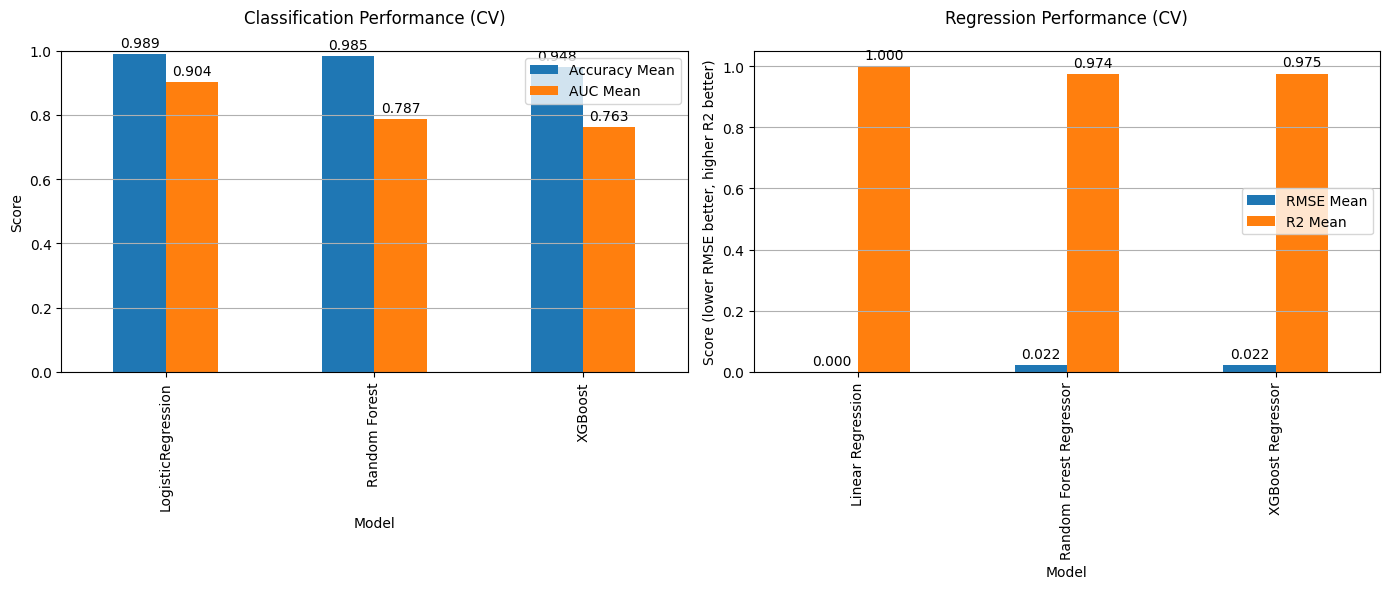

Classification Performance with Standard Deviation (Cross Validation)
                Model  Accuracy Std   AUC Std
0  LogisticRegression      0.003998  0.122368
1       Random Forest      0.011860  0.261494
2             XGBoost      0.081947  0.275447

Regression Performance with Standard Deviation (Cross Validation)
                     Model      RMSE Std        R2 Std
0        Linear Regression  2.095673e-07  1.898369e-11
1  Random Forest Regressor  1.381031e-02  1.363428e-02
2        XGBoost Regressor  1.770208e-02  1.902124e-02


In [17]:
# Classification and Regression Model Testing Using Cross Validation

cv_clf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_reg = KFold(n_splits=5, shuffle=True, random_state=42)

clf_results_cv = []
reg_results_cv = []

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

cv_reg = 5
reg_results_cv = []

for name, model in clf_models.items():
    pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', model)])
    scores = cross_validate(pipe, X_clf, y_clf, cv=5,
                            scoring=['accuracy', 'roc_auc'],
                            return_train_score=False)
    
    clf_results_cv.append({
        'Model': name,
        'Accuracy Mean': scores['test_accuracy'].mean(),
        'Accuracy Std': scores['test_accuracy'].std(),
        'AUC Mean': scores['test_roc_auc'].mean(),
        'AUC Std': scores['test_roc_auc'].std()
    })


for name, model in reg_models.items():
    pipe = Pipeline([('preprocess', preprocessor), ('model', model)])
    scores = cross_validate(pipe, X_reg, y_reg, cv=cv_reg,
                            scoring={'rmse': make_scorer(rmse_score, greater_is_better=False),
                                     'r2': make_scorer(r2_score)},
                            return_train_score=False)
    reg_results_cv.append({
        'Model': name,
        'RMSE Mean': -np.mean(scores['test_rmse']),  
        'RMSE Std': np.std(scores['test_rmse']),
        'R2 Mean': np.mean(scores['test_r2']),
        'R2 Std': np.std(scores['test_r2'])
    })

df_clf_cv = pd.DataFrame(clf_results_cv)
df_reg_cv = pd.DataFrame(reg_results_cv)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

df_clf_cv.plot(x='Model', y=['Accuracy Mean', 'AUC Mean'], kind='bar', ax=axs[0])
axs[0].set_title("Classification Performance (CV)", pad=20)
axs[0].set_ylim(0, 1)
axs[0].set_ylabel("Score")
axs[0].grid(True, axis='y')
for container in axs[0].containers:
    axs[0].bar_label(container, fmt='%.3f', label_type='edge', padding=3)

df_reg_cv.plot(x='Model', y=['RMSE Mean', 'R2 Mean'], kind='bar', ax=axs[1])
axs[1].set_title("Regression Performance (CV)", pad=20)
axs[1].set_ylabel("Score (lower RMSE better, higher R2 better)")
axs[1].grid(True, axis='y')
for container in axs[1].containers:
    axs[1].bar_label(container, fmt='%.3f', label_type='edge', padding=3)

plt.tight_layout()
plt.show()

print("Classification Performance with Standard Deviation (Cross Validation)")
print(df_clf_cv[['Model', 'Accuracy Std', 'AUC Std']])

print("\nRegression Performance with Standard Deviation (Cross Validation)")
print(df_reg_cv[['Model', 'RMSE Std', 'R2 Std']])


Classification Models
* Logistic Regression - While the model is very stable in accuracy across folds, the AUC varies more
    * Top-performing model
* Random Forest - Compared to logistic, it has slightly more variability in accuracy and AUC
    * Great performance but more volatile that logistic
* XGBoost - Has the highest variability in both. It is less consistent in performance across folds
    * Higher variability could be caused by class imbalance or sensitivity to decision thresholds

Regression Models
* Linear Regression - Has extremely low variance, showing almost identical performance across folds 
    * Could be due to its simple structure (PCA score is linear in nature)
* Random Forest Regressor - Has low variance, but isn't as great as linear
* XGBoost Regressor - Shows slighltly more variance than Random Forest, but still stable

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:10:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:10:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:10:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:10:57] WARN

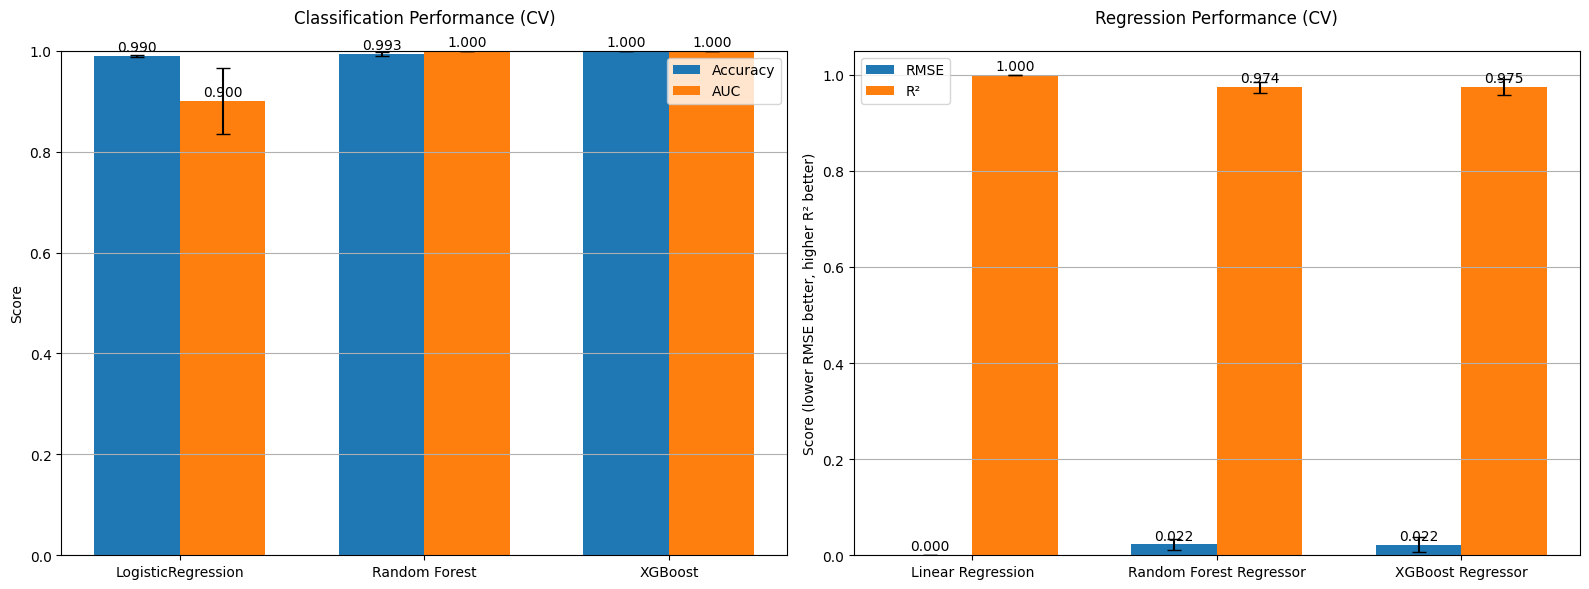

Classification 95% Confidence Intervals:
                Model  Accuracy Mean  Accuracy CI  AUC Mean    AUC CI
0  LogisticRegression       0.989781     0.001280  0.900192  0.065114
1       Random Forest       0.993431     0.003731  1.000000  0.000000
2             XGBoost       1.000000     0.000000  1.000000  0.000000

Regression 95% Confidence Intervals:
                     Model     RMSE Mean       RMSE CI   R2 Mean         R2 CI
0        Linear Regression  2.737203e-07  1.836939e-07  1.000000  1.663994e-11
1  Random Forest Regressor  2.245919e-02  1.243845e-02  0.974245  1.145979e-02
2        XGBoost Regressor  2.198592e-02  1.551656e-02  0.975267  1.667285e-02


In [23]:
# Regression and Classification with 95% Confidence Intervals
clf_results_cv = []
reg_results_cv = []

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse_score, greater_is_better=False) 

for name, model in clf_models.items():
    pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', model)])
    scores = cross_validate(pipe, X_clf, y_clf, cv=cv_clf,
                            scoring={'accuracy': 'accuracy', 'roc_auc': 'roc_auc'},
                            return_train_score=False)
    
    n_folds = cv_clf.get_n_splits()
    clf_results_cv.append({
        'Model': name,
        'Accuracy Mean': scores['test_accuracy'].mean(),
        'Accuracy Std': scores['test_accuracy'].std(),
        'Accuracy CI': 1.96 * scores['test_accuracy'].std() / sqrt(n_folds),
        'AUC Mean': scores['test_roc_auc'].mean(),
        'AUC Std': scores['test_roc_auc'].std(),
        'AUC CI': 1.96 * scores['test_roc_auc'].std() / sqrt(n_folds)
    })

for name, model in reg_models.items():
    pipe = Pipeline([('preprocess', preprocessor), ('model', model)])
    
    scores = cross_validate(pipe, X_reg, y_reg, cv=cv_reg,
                            scoring={'rmse': rmse_scorer, 'r2': make_scorer(r2_score)},
                            return_train_score=False)
    
    rmse_scores = -scores['test_rmse']  
    r2_scores = scores['test_r2']
    
    reg_results_cv.append({
        'Model': name,
        'RMSE Mean': rmse_scores.mean(),
        'RMSE Std': rmse_scores.std(),
        'RMSE CI': 1.96 * rmse_scores.std() / sqrt(cv_reg),
        'R2 Mean': r2_scores.mean(),
        'R2 Std': r2_scores.std(),
        'R2 CI': 1.96 * r2_scores.std() / sqrt(cv_reg)
    })

df_reg_cv = pd.DataFrame(reg_results_cv)
df_clf_cv = pd.DataFrame(clf_results_cv)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

x_clf = np.arange(len(df_clf_cv))
width = 0.35
axs[0].bar(x_clf - width/2, df_clf_cv['Accuracy Mean'], width, label='Accuracy',
           yerr=df_clf_cv['Accuracy CI'], capsize=5)
axs[0].bar(x_clf + width/2, df_clf_cv['AUC Mean'], width, label='AUC',
           yerr=df_clf_cv['AUC CI'], capsize=5)

for i, v in enumerate(df_clf_cv['Accuracy Mean']):
    axs[0].text(x_clf[i] - width/2, v + 0.01, f"{v:.3f}", ha='center')
for i, v in enumerate(df_clf_cv['AUC Mean']):
    axs[0].text(x_clf[i] + width/2, v + 0.01, f"{v:.3f}", ha='center')

axs[0].set_xticks(x_clf)
axs[0].set_xticklabels(df_clf_cv['Model'])
axs[0].set_title("Classification Performance (CV)", pad=20)
axs[0].set_ylim(0, 1)
axs[0].set_ylabel("Score")
axs[0].legend()
axs[0].grid(True, axis='y')

x_reg = np.arange(len(df_reg_cv))
axs[1].bar(x_reg - width/2, df_reg_cv['RMSE Mean'], width, label='RMSE',
           yerr=df_reg_cv['RMSE CI'], capsize=5)
axs[1].bar(x_reg + width/2, df_reg_cv['R2 Mean'], width, label='R²',
           yerr=df_reg_cv['R2 CI'], capsize=5)

for i, v in enumerate(df_reg_cv['RMSE Mean']):
    axs[1].text(x_reg[i] - width/2, v + 0.01, f"{v:.3f}", ha='center')
for i, v in enumerate(df_reg_cv['R2 Mean']):
    axs[1].text(x_reg[i] + width/2, v + 0.01, f"{v:.3f}", ha='center')

axs[1].set_xticks(x_reg)
axs[1].set_xticklabels(df_reg_cv['Model'])
axs[1].set_title("Regression Performance (CV)", pad=20)
axs[1].set_ylabel("Score (lower RMSE better, higher R² better)")
axs[1].legend()
axs[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

print("Classification 95% Confidence Intervals:")
print(df_clf_cv[['Model', 'Accuracy Mean', 'Accuracy CI', 'AUC Mean', 'AUC CI']])
print("\nRegression 95% Confidence Intervals:")
print(df_reg_cv[['Model', 'RMSE Mean', 'RMSE CI', 'R2 Mean', 'R2 CI']])

Classification 
* Logistic Regression - Has very tight Accuracy CI, but the wider AUC CI suggests some variabiliy in rank-order separation
* Random Forest - Better than logistic. Shows excellent and consistent performance across both metrics
* XGBoost - Perfect score. Will need to check if it's overfitting or the data itself is too easy to classify

Regression
* Linear Regression - Has nearly perfect fit with no meaningful variance. This could be due to simple linear nature of PCA
* Random Forest Regressor - Shows great performance with small variability
* XGBoost - Nearly identical to Random Forest, but with slightly wider CIs

Investigate XGBoost overfitting in Classification

In [25]:
# Check training vs test scores
xgb_model = clf_models['XGBoost']
pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', xgb_model)])

scores = cross_validate(pipe, X_clf, y_clf, cv=cv_clf, scoring={'accuracy': 'accuracy', 'roc_auc': 'roc_auc'}, return_train_score=True)

print("Train Accuracy Mean:", scores['train_accuracy'].mean())
print("Test Accuracy Mean :", scores['test_accuracy'].mean())
print("Train AUC Mean     :", scores['train_roc_auc'].mean())
print("Test AUC Mean      :", scores['test_roc_auc'].mean())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:12:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:12:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:12:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train Accuracy Mean: 1.0
Test Accuracy Mean : 1.0
Train AUC Mean     : 1.0
Test AUC Mean      : 1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:12:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:12:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


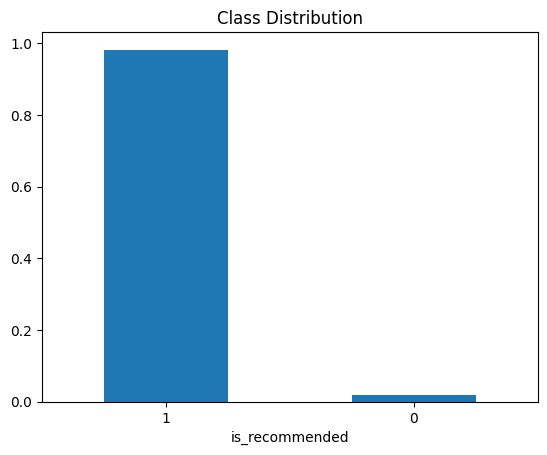

In [26]:
# Check class balance
y_clf.value_counts(normalize=True).plot(kind='bar', title="Class Distribution")
plt.xticks(rotation=0)
plt.show()

In [34]:
# Enable early stopping to monitor generalization

X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train_prep, label=y_train)
dval = xgb.DMatrix(X_val_prep, label=y_val)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1,
    'lambda': 1.0
}

evals = [(dtrain, 'train'), (dval, 'eval')]
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=True
)

y_pred_prob = booster.predict(dval)
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred)

print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation AUC     : {auc:.4f}")


[0]	train-logloss:0.08094	eval-logloss:0.08621
[1]	train-logloss:0.07487	eval-logloss:0.08068
[2]	train-logloss:0.06990	eval-logloss:0.07662
[3]	train-logloss:0.06446	eval-logloss:0.07219
[4]	train-logloss:0.06078	eval-logloss:0.06873
[5]	train-logloss:0.05710	eval-logloss:0.06773
[6]	train-logloss:0.05390	eval-logloss:0.06537


[7]	train-logloss:0.05190	eval-logloss:0.06288
[8]	train-logloss:0.04947	eval-logloss:0.06115
[9]	train-logloss:0.04696	eval-logloss:0.05885
[10]	train-logloss:0.04535	eval-logloss:0.05746
[11]	train-logloss:0.04281	eval-logloss:0.05466
[12]	train-logloss:0.04121	eval-logloss:0.05408
[13]	train-logloss:0.03955	eval-logloss:0.05231
[14]	train-logloss:0.03768	eval-logloss:0.05004
[15]	train-logloss:0.03643	eval-logloss:0.04880
[16]	train-logloss:0.03433	eval-logloss:0.04615
[17]	train-logloss:0.03340	eval-logloss:0.04552
[18]	train-logloss:0.03202	eval-logloss:0.04360
[19]	train-logloss:0.03130	eval-logloss:0.04358
[20]	train-logloss:0.03065	eval-logloss:0.04255
[21]	train-logloss:0.02916	eval-logloss:0.04055
[22]	train-logloss:0.02811	eval-logloss:0.03907
[23]	train-logloss:0.02695	eval-logloss:0.03750
[24]	train-logloss:0.02625	eval-logloss:0.03741
[25]	train-logloss:0.02530	eval-logloss:0.03611
[26]	train-logloss:0.02426	eval-logloss:0.03456
[27]	train-logloss:0.02334	eval-logloss:0.0

In [40]:
# Look at feature importances
if isinstance(xgb_model, (XGBClassifier, XGBRegressor)):
    booster = xgb_model.get_booster()
    importance = booster.get_score(importance_type='weight')
    
    feature_names = pipe.named_steps['preprocess'].get_feature_names_out()
    
    importance_named = {feature_names[int(k[1:])]: v for k, v in importance.items() if k.startswith('f')}

    sorted_importance = dict(sorted(importance_named.items(), key=lambda x: x[1], reverse=True))
    for feature, score in sorted_importance.items():
        print(f"{feature}: {score}")
else:
    print("The model is not an XGBoost model.")

num__review_volume: 77.0
num__rating: 57.0
num__avg_sentiment_score: 28.0
num__price_usd: 28.0
cat__tertiary_category_Face Wash & Cleansers: 9.0


Based on these tests, XGBoost is likely overfitting
* Has unrealistically CV scores
* Strong class imbalance as the graph demonstrates
* Much lower  AUC on validation set with early stopping
* Heavy dependence on few features

To address this issue, try Synthetic Minority Over-sampling Technique (SMOTE) before training
* Because SMOTE is compatible with older versions of scikit, we will downgrade the scikit version 

In [54]:
pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0 xgboost==1.7.6

  Using cached scikit_learn-1.3.2-cp312-cp312-macosx_12_0_arm64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.2-cp312-cp312-macosx_12_0_arm64.whl (9.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.6 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.0.2
    Uninstalling xgboost-3.0.2:
      Successfully uninstalled xgboost-3.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.0
    Uninstalling scikit-learn-1.7.0:
      Successfully uninstalled scikit-learn-1.7.0
  Attempting uninstall: imbalanced-learn━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/3 [scikit-learn]
    Found existing installation: imbalanced-learn 0.13.0━━━━━━ 1/3 [scikit-learn]
    Uninstalling imbalanced-learn-0.13.0:━━━━━━━━━━━━━━━━━━━━━ 1/3 [scikit-learn]
      Successfully uninstalled imbalanced-learn-0.13.0━━━━━━━━ 1/3 [scikit-learn]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [imbalanced-learn][imbalanced-learn]

[notice] A ne

In [61]:
pip install --upgrade imbalanced-learn

  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.11.0
    Uninstalling imbalanced-learn-0.11.0:
      Successfully uninstalled imbalanced-learn-0.11.0

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [62]:
# SMOTE
from imblearn.over_sampling import SMOTE

df_reviews = pd.read_csv("clean_data/skincare_reviews_clean.csv")
df_reviews['sentiment_score'] = df_reviews['sentiment'].map({'label_2': 1, 'label_1': 0, 'label_0': -1})

avg_sentiment = df_reviews.groupby('product_id')['sentiment_score'].mean().reset_index().rename(columns={'sentiment_score': 'avg_sentiment_score'})
volume = df_reviews['product_id'].value_counts().reset_index()
volume.columns = ['product_id', 'review_volume']

meta = df_reviews.drop_duplicates('product_id')[['product_id', 'price_usd', 'secondary_category', 'tertiary_category', 'skin_type', 'rating', 'is_recommended']]

df = meta.merge(avg_sentiment, on='product_id').merge(volume, on='product_id')
df = df.dropna(subset=['is_recommended'])
df['is_recommended'] = df['is_recommended'].astype(int)

numeric_features = ['rating', 'avg_sentiment_score', 'review_volume', 'price_usd']
categorical_features = ['secondary_category', 'tertiary_category', 'skin_type']
features = numeric_features + categorical_features

X = df[features]
y = df['is_recommended'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_features)
])

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_prep, y_train)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_resampled, y_resampled)

y_pred = xgb.predict(X_test_prep)
y_proba = xgb.predict_proba(X_test_prep)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Test AUC:", roc_auc_score(y_test, y_proba))

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_1946/16005231.py:4: DtypeWarning: Columns (0,1,2,3,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_reviews = pd.read_csv("clean_data/skincare_reviews_clean.csv")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:45:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.23      0.23        22
           1       0.66      0.66      0.66        50

    accuracy                           0.53        72
   macro avg       0.44      0.44      0.44        72
weighted avg       0.53      0.53      0.53        72

Test AUC: 0.5154545454545454


* AUC of 0.515 is barely better than random guessing
* After applying SMOTE, the model showed slight improvement in precision and recall of 0.23 for class 0, instead of 0.00
    * It helped a little but not enough. Performance is still considered poor

In [67]:
# Check rating and sentiment distribution by recommendation
df_reviews[['rating', 'sentiment', 'is_recommended']].groupby(['is_recommended', 'sentiment']).agg(['count', 'mean'])

rating          
                           count      mean
is_recommended sentiment                  
0.0            label_0     14477  4.213162
               label_1      3010  4.236870
               label_2      7733  4.254532
1.0            label_0     10175  4.333045
               label_1      8305  4.322255
               label_2    203769  4.346324
               neutral         8  4.522600

* A huge part of samples are noisy = sentiment and is_recommended tend to disagree
* Most ratings are still above 4.0, which is the case for even negative setiments
* This shows that is_recommended is not reliable since 0s and 1s are found across all sentiment classes and high ratings
* This could be due to user idiosyncrasies and not true product quality or satisfaction

Discard is_recommended and create a clean proxy label as a more objectve target for classification model

In [74]:
# Build reco_clean
df_skincare_reviews_clean['sentiment'] = df_skincare_reviews_clean['sentiment'].astype(str)  
df_skincare_reviews_clean['reco_clean'] = np.where(
    ((df_skincare_reviews_clean['is_recommended'] == 1) & (df_skincare_reviews_clean['sentiment'] == 'label_2')) |
    ((df_skincare_reviews_clean['is_recommended'] == 0) & (df_skincare_reviews_clean['sentiment'] == 'label_0')),
    df_skincare_reviews_clean['is_recommended'], 
    np.nan  
)

df_skincare_reviews_clean = df_skincare_reviews_clean.dropna(subset=['reco_clean'])

df_skincare_reviews_clean['reco_clean'] = df_skincare_reviews_clean['reco_clean'].astype(int)

print("New target distribution (reco_clean):")
print(df_skincare_reviews_clean['reco_clean'].value_counts(normalize=True).round(3))

New target distribution (reco_clean):
reco_clean
1    0.934
0    0.066
Name: proportion, dtype: float64


* 93.4% labeled as recommended and 6.6% labeled as not recommended
* Data is still very skewed even after cleaning to remove contradictory cases
* This will still bias classifiers towards the majority class (recommended)

Solution:
* Apply SMOTE on reco_clean to synthetically balance the minority class and retrain classifier

In [86]:
sentiment_map = {'label_0': -1, 'label_1': 0, 'label_2': 1}
df_reviews['sentiment_score'] = df_reviews['sentiment'].map(sentiment_map)

agg_df = df_reviews.groupby('product_id').agg({
    'sentiment_score': 'mean',
    'product_name': 'first',
    'rating': 'mean',
    'price_usd': 'first',
    'skin_type': 'first',
    'tertiary_category': 'first',
    'secondary_category': 'first',
    'is_recommended': 'mean',
    'reco_clean': 'first'
}).rename(columns={
    'sentiment_score': 'avg_sentiment_score',
    'rating': 'rating',
    'is_recommended': 'review_volume'
}).reset_index()

agg_df = agg_df[agg_df['reco_clean'].notna()]
agg_df['reco_clean'] = agg_df['reco_clean'].astype(int)

numeric_features = ['rating', 'avg_sentiment_score', 'review_volume', 'price_usd']
categorical_features = ['secondary_category', 'tertiary_category', 'skin_type']
features = numeric_features + categorical_features

X = agg_df[features]
y = agg_df['reco_clean']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_features),
    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_features)
])

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_prep, y_train)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_resampled, y_resampled)

y_pred = xgb.predict(X_test_prep)
y_proba = xgb.predict_proba(X_test_prep)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Test AUC:", roc_auc_score(y_test, y_proba))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:46:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.84      0.86        44
           1       0.89      0.92      0.90        62

    accuracy                           0.89       106
   macro avg       0.89      0.88      0.88       106
weighted avg       0.89      0.89      0.89       106

Test AUC: 0.8848973607038122


* Class balance, 44 vs 62, is not perfectly balanced but it's close enough that SMOTE model handled it well
* Accuracy of 0.89, very good prediction rate
* AUC of 0.885, strong discriminatory power between classes
* reco_clean is more data-aligned improvement from the original is_recommended

Next steps:
* Use reco_clean for downstream classification work

In [88]:
# Cross-Validation with SMOTE Pipeline (StratifiedKFold)
from imblearn.pipeline import Pipeline as ImbPipeline

numeric_features = ['rating', 'avg_sentiment_score', 'review_volume', 'price_usd']
categorical_features = ['secondary_category', 'tertiary_category', 'skin_type']
features = numeric_features + categorical_features

X = agg_df[features]
y = agg_df['reco_clean']

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_features),
    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_features)
])

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', model)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'auc': make_scorer(roc_auc_score)
}

scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring['auc'])

print("Mean AUC across folds:", np.mean(scores))
print("Standard Deviation of AUC:", np.std(scores))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:30:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:30:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:30:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:30:25] WARN

Mean AUC across folds: 0.8617977768162856
Standard Deviation of AUC: 0.017061109882993707


In [115]:
# Rebuild classification pipeline wiht reco_clean

df = df_reviews.copy()
sentiment_map = {'label_0': -1, 'label_1': 0, 'label_2': 1}
df['sentiment_score'] = df['sentiment'].map(sentiment_map)

df['sentiment'] = df['sentiment'].astype(str)
df['reco_clean'] = np.where(
    ((df['is_recommended'] == 1) & (df['sentiment'] == 'label_2')) |
    ((df['is_recommended'] == 0) & (df['sentiment'] != 'label_2')),
    1, 0
)

df = df[df['reco_clean'].notna()]
df['reco_clean'] = df['reco_clean'].astype(int)

agg_df = df.groupby('product_id').agg({
    'sentiment_score': 'mean',
    'product_name': 'first',
    'rating': 'mean',
    'price_usd': 'first',
    'skin_type': 'first',
    'tertiary_category': 'first',
    'secondary_category': 'first',
    'reco_clean': 'first'
}).reset_index()

agg_df['review_volume'] = df.groupby('product_id').size().values

numeric_features = ['rating', 'sentiment_score', 'review_volume', 'price_usd']
categorical_features = ['secondary_category', 'tertiary_category', 'skin_type']
features = numeric_features + categorical_features

X = agg_df[features]
y = agg_df['reco_clean']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_features)
])

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_prep, y_train)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_resampled, y_resampled)

y_pred = xgb.predict(X_test_prep)
y_proba = xgb.predict_proba(X_test_prep)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Test AUC:", roc_auc_score(y_test, y_proba))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:43:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88        41
           1       0.92      0.92      0.92        65

    accuracy                           0.91       106
   macro avg       0.90      0.90      0.90       106
weighted avg       0.91      0.91      0.91       106

Test AUC: 0.9500938086303939


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:45:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:45:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:45:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:45:55] WARN

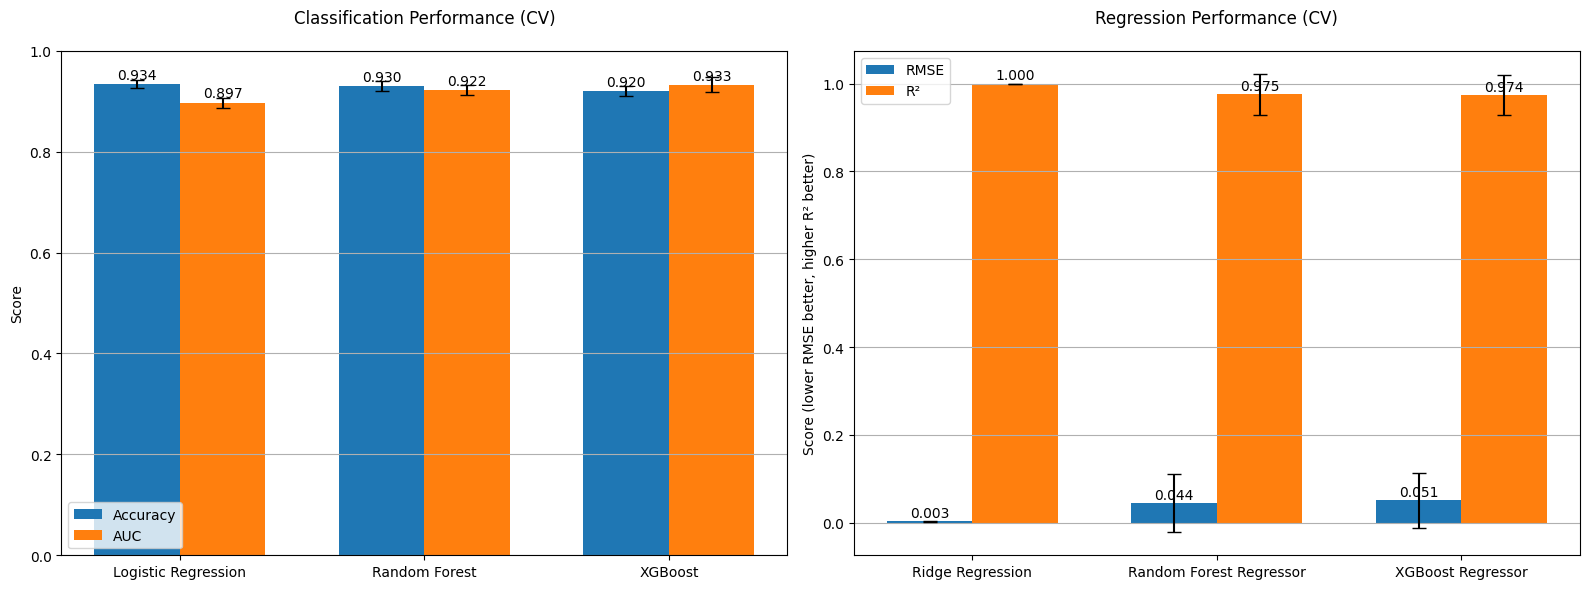

Classification Results:
                  Model  Accuracy Mean  Accuracy Std  AUC Mean   AUC Std
0  Logistic Regression       0.933729      0.008322  0.897420  0.009863
1        Random Forest       0.929919      0.009732  0.922169  0.010023
2              XGBoost       0.920485      0.009395  0.932919  0.014997

Regression Results:
                      Model  RMSE Mean  RMSE Std   R2 Mean    R2 Std
0         Ridge Regression   0.003017  0.000511  0.999937  0.000021
1  Random Forest Regressor   0.043948  0.065906  0.975421  0.047284
2        XGBoost Regressor   0.050715  0.061859  0.974134  0.045472


In [119]:
sentiment_map = {'label_0': -1, 'label_1': 0, 'label_2': 1}
df_reviews['sentiment_score'] = df_reviews['sentiment'].map(sentiment_map)
df_reviews['reco_clean'] = np.where(
    ((df_reviews['is_recommended'] == 1) & (df_reviews['sentiment_score'] == 1)) |
    ((df_reviews['is_recommended'] == 0) & (df_reviews['sentiment_score'] != 1)),
    1, 0
)

df = df_reviews.copy()
df = df[df['reco_clean'].notna()]
df['reco_clean'] = df['reco_clean'].astype(int)

agg_df = df.groupby('product_id').agg({
    'sentiment_score': 'mean',
    'product_name': 'first',
    'rating': 'mean',
    'price_usd': 'first',
    'skin_type': 'first',
    'tertiary_category': 'first',
    'secondary_category': 'first',
    'reco_clean': 'first',
    'review_text': 'count'  
}).rename(columns={
    'sentiment_score': 'avg_sentiment_score',
    'review_text': 'review_volume'
}).reset_index()

numeric_features = ['rating', 'avg_sentiment_score', 'review_volume', 'price_usd']
categorical_features = ['secondary_category', 'tertiary_category', 'skin_type']
features = numeric_features + categorical_features

X_clf = agg_df[features]
y_clf = agg_df['reco_clean']
X_reg = agg_df[features]
y_reg = agg_df['rating']
valid_idx = y_reg.notna()
X_reg = X_reg[valid_idx]
y_reg = y_reg[valid_idx]
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_features)
])

clf_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

reg_models = {
    'Ridge Regression': Ridge(),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'XGBoost Regressor': XGBRegressor(random_state=42)
}

cv_clf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_reg = KFold(n_splits=5, shuffle=True, random_state=42)

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

clf_results_cv = []
reg_results_cv = []

for name, model in clf_models.items():
    pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', model)])
    scores = cross_validate(pipe, X_clf, y_clf, cv=cv_clf,
                            scoring=['accuracy', 'roc_auc'],
                            return_train_score=False)

    clf_results_cv.append({
        'Model': name,
        'Accuracy Mean': scores['test_accuracy'].mean(),
        'Accuracy Std': scores['test_accuracy'].std(),
        'AUC Mean': scores['test_roc_auc'].mean(),
        'AUC Std': scores['test_roc_auc'].std()
    })

for name, model in reg_models.items():
    pipe = Pipeline([('preprocess', preprocessor), ('model', model)])
    scores = cross_validate(pipe, X_reg, y_reg, cv=cv_reg,
                            scoring={'rmse': make_scorer(rmse_score, greater_is_better=False),
                                     'r2': make_scorer(r2_score)},
                            return_train_score=False)

    reg_results_cv.append({
        'Model': name,
        'RMSE Mean': -np.mean(scores['test_rmse']),
        'RMSE Std': np.std(scores['test_rmse']),
        'R2 Mean': np.mean(scores['test_r2']),
        'R2 Std': np.std(scores['test_r2'])
    })

df_clf_cv = pd.DataFrame(clf_results_cv)
df_reg_cv = pd.DataFrame(reg_results_cv)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
width = 0.35

x_clf = np.arange(len(df_clf_cv))
axs[0].bar(x_clf - width/2, df_clf_cv['Accuracy Mean'], width,
           yerr=df_clf_cv['Accuracy Std'], capsize=5, label='Accuracy')
axs[0].bar(x_clf + width/2, df_clf_cv['AUC Mean'], width,
           yerr=df_clf_cv['AUC Std'], capsize=5, label='AUC')

for i, v in enumerate(df_clf_cv['Accuracy Mean']):
    axs[0].text(x_clf[i] - width/2, v + 0.01, f"{v:.3f}", ha='center')
for i, v in enumerate(df_clf_cv['AUC Mean']):
    axs[0].text(x_clf[i] + width/2, v + 0.01, f"{v:.3f}", ha='center')

axs[0].set_xticks(x_clf)
axs[0].set_xticklabels(df_clf_cv['Model'])
axs[0].set_title("Classification Performance (CV)", pad=20)
axs[0].set_ylim(0, 1)
axs[0].set_ylabel("Score")
axs[0].legend()
axs[0].grid(True, axis='y')

x_reg = np.arange(len(df_reg_cv))
axs[1].bar(x_reg - width/2, df_reg_cv['RMSE Mean'], width,
           yerr=df_reg_cv['RMSE Std'], capsize=5, label='RMSE')
axs[1].bar(x_reg + width/2, df_reg_cv['R2 Mean'], width,
           yerr=df_reg_cv['R2 Std'], capsize=5, label='R²')

for i, v in enumerate(df_reg_cv['RMSE Mean']):
    axs[1].text(x_reg[i] - width/2, v + 0.01, f"{v:.3f}", ha='center')
for i, v in enumerate(df_reg_cv['R2 Mean']):
    axs[1].text(x_reg[i] + width/2, v + 0.01, f"{v:.3f}", ha='center')

axs[1].set_xticks(x_reg)
axs[1].set_xticklabels(df_reg_cv['Model'])
axs[1].set_title("Regression Performance (CV)", pad=20)
axs[1].set_ylabel("Score (lower RMSE better, higher R² better)")
axs[1].legend()
axs[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

print("Classification Results:\n", df_clf_cv)
print("\nRegression Results:\n", df_reg_cv)

Classification
* Logistic Regression - strong performance on balanced accuracy, slightly lower AUC. Fits general patterns well with fewer chances of overfitting
* Random Foprest - has the highest AUC, which means it distinguishes positive vs negative better than others
* XGBoost - slightly lower accuracy, but best AUC. It better captures probability ranking, which is critical for real-world recommendation systems
    * If ranking quality matters most, XGBoost might be the best choice

Regression
* Ridge Regression - its nearly perfect fit could be due to the numeric target being very stable or deterministic
* Random Forest Regressor - Strong fit, robust model. More felxible but has slightly more error than Ridge
* XGBoost Regressor - Slightly higher error but very competitive R2. Good for cpaturing complex nonlinearities

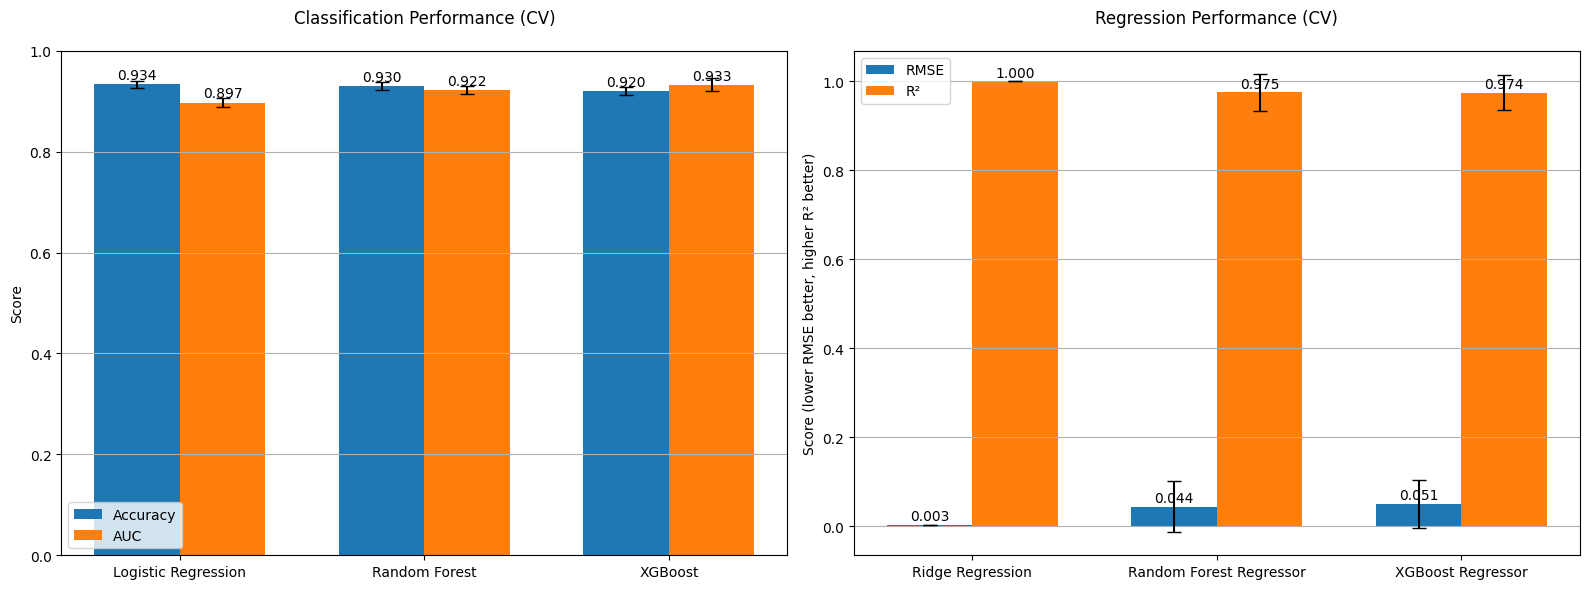


Classification CI:
                 Model  Accuracy CI    AUC CI
0  Logistic Regression     0.007294  0.008645
1        Random Forest     0.008530  0.008785
2              XGBoost     0.008235  0.013146

Regression CI:
                     Model   RMSE CI     R2 CI
0         Ridge Regression  0.000448  0.000018
1  Random Forest Regressor  0.057769  0.041446
2        XGBoost Regressor  0.054222  0.039858


In [117]:
n_folds = 5  
z = 1.96     

df_clf_cv['Accuracy CI'] = z * df_clf_cv['Accuracy Std'] / sqrt(n_folds)
df_clf_cv['AUC CI'] = z * df_clf_cv['AUC Std'] / sqrt(n_folds)

df_reg_cv['RMSE CI'] = z * df_reg_cv['RMSE Std'] / sqrt(n_folds)
df_reg_cv['R2 CI'] = z * df_reg_cv['R2 Std'] / sqrt(n_folds)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
width = 0.35

x_clf = np.arange(len(df_clf_cv))
axs[0].bar(x_clf - width/2, df_clf_cv['Accuracy Mean'], width,
           yerr=df_clf_cv['Accuracy CI'], capsize=5, label='Accuracy')
axs[0].bar(x_clf + width/2, df_clf_cv['AUC Mean'], width,
           yerr=df_clf_cv['AUC CI'], capsize=5, label='AUC')

# Add labels
for i, v in enumerate(df_clf_cv['Accuracy Mean']):
    axs[0].text(x_clf[i] - width/2, v + 0.01, f"{v:.3f}", ha='center')
for i, v in enumerate(df_clf_cv['AUC Mean']):
    axs[0].text(x_clf[i] + width/2, v + 0.01, f"{v:.3f}", ha='center')

axs[0].set_xticks(x_clf)
axs[0].set_xticklabels(df_clf_cv['Model'])
axs[0].set_title("Classification Performance (CV)", pad=20)
axs[0].set_ylim(0, 1)
axs[0].set_ylabel("Score")
axs[0].legend()
axs[0].grid(True, axis='y')

x_reg = np.arange(len(df_reg_cv))
axs[1].bar(x_reg - width/2, df_reg_cv['RMSE Mean'], width,
           yerr=df_reg_cv['RMSE CI'], capsize=5, label='RMSE')
axs[1].bar(x_reg + width/2, df_reg_cv['R2 Mean'], width,
           yerr=df_reg_cv['R2 CI'], capsize=5, label='R²')

for i, v in enumerate(df_reg_cv['RMSE Mean']):
    axs[1].text(x_reg[i] - width/2, v + 0.01, f"{v:.3f}", ha='center')
for i, v in enumerate(df_reg_cv['R2 Mean']):
    axs[1].text(x_reg[i] + width/2, v + 0.01, f"{v:.3f}", ha='center')

axs[1].set_xticks(x_reg)
axs[1].set_xticklabels(df_reg_cv['Model'])
axs[1].set_title("Regression Performance (CV)", pad=20)
axs[1].set_ylabel("Score (lower RMSE better, higher R² better)")
axs[1].legend()
axs[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

print("\nClassification CI:")
print(df_clf_cv[['Model', 'Accuracy CI', 'AUC CI']])

print("\nRegression CI:")
print(df_reg_cv[['Model', 'RMSE CI', 'R2 CI']])

Classification
* Logistic Regression - has the most stable performance
* Random Forest - stable accuracy, AUC is more variable (could be due to class imbalance or sensitivity to splits)
* XGBoost - shows greater variance, suggesting it might benefit from more tuning or regularization

Regression
* Ridge regression - very consistent and extremely stable, possibly due to deterministic patterns in the data
* Random Forest Regressor - Much higher variance and performance tends to fluctuate more across folds
* XGBoost Regressor - Similar variance to Random Forest, indicating that nonlinear models are more affected by fold splits

In [120]:
agg_df.to_csv("clean_data/agg_df_clean.csv", index=False)

## Model Evaluation and Visualization

In [132]:
# Drop rows with missing review_text
valid_sentiment_df = df_reviews[df_reviews['review_text'].notna()]

# Sample 10 reviews with predicted sentiment
valid_sentiment_df[['review_text', 'sentiment']].sample(10, random_state=42)

,review_text,sentiment
20798,I tried the mini size and decided to really go...,label_2
210600,I received this product as a free sample from ...,label_2
264890,My new go to! When I got off BCP I suffered fr...,label_2
239678,AMAZING!!!! My skins feels soooo hydrated when...,label_2
195938,I have dry flakey skin and this product does a...,label_2
8443,I LOOOVE this product! It’s my complete facial...,label_2
196904,The original version was my first “real“ clea...,label_0
48104,I’m obsessed with the smell of all korres yogh...,label_2
204700,I have combo skin and don’t usually have a pro...,label_0
256062,immediate improvement to the dark circles unde...,label_2


In [145]:
import joblib
# Build XGBoost classifier pipeline
xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', clf_models['XGBoost'])
])
xgb_pipeline.fit(X_clf, y_clf)
joblib.dump(xgb_pipeline, 'saved_models/classifier_xgboost_pipeline.pkl')

# Build Random Forest regressor pipeline
rf_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', reg_models['Random Forest Regressor'])
])
rf_pipeline.fit(X_reg, y_reg)
joblib.dump(rf_pipeline, 'saved_models/regressor_rf_pipeline.pkl')


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:08:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


['saved_models/regressor_rf_pipeline.pkl']

In [147]:
# Load pipelines
xgb_pipeline = joblib.load('saved_models/classifier_xgboost_pipeline.pkl')
rf_pipeline = joblib.load('saved_models/regressor_rf_pipeline.pkl')

# Reload product-level data
agg_df = pd.read_csv('clean_data/agg_df_clean.csv')

# Use exact same features used during training
features = ['rating', 'avg_sentiment_score', 'review_volume', 'price_usd',
            'secondary_category', 'tertiary_category', 'skin_type']
X_all = agg_df[features]

# Use pipeline directly (handles preprocessing)
agg_df['recommend_proba'] = xgb_pipeline.predict_proba(X_all)[:, 1]
agg_df['predicted_popularity'] = rf_pipeline.predict(X_all)

# Final scoring
agg_df['score'] = (
    0.5 * agg_df['recommend_proba'] +
    0.5 * (agg_df['predicted_popularity'] / agg_df['predicted_popularity'].max())
)

top_recommendations = agg_df.sort_values('score', ascending=False).head(10)
top_recommendations[['product_id', 'product_name', 'score', 'recommend_proba', 'predicted_popularity']]


,product_id,product_name,score,recommend_proba,predicted_popularity
481,P505174,Soft Clean Moisture Rich Foaming Cleanser,0.997112,0.994223,5.000000
483,P505316,Aquarius BHA + Blue Tansy Clarity Cleanser,0.996660,0.995934,4.986927
467,P504417,Acne Treatment Gel,0.996276,0.993167,4.996924
372,P476496,Instant Reset Brightening Overnight Recovery G...,0.994589,0.989486,4.998462
456,P503877,Superkind Refining Cleanser,0.993856,0.988480,4.996155
458,P503915,Mini Floral Recovery Overnight Mask with Squalane,0.993425,0.986850,5.000000
464,P504053,Capture Dreamskin 1-Minute Mask,0.993316,0.986940,4.998462
373,P476571,Turbo Body Lotion Energizing Gel Moisturizer w...,0.989760,0.979521,5.000000
391,P479946,Self Tanning Face & Body Tinted Gel,0.988809,0.977619,5.000000
480,P505133,High Performance Face Cleanser for Clear Skin ...,0.986802,0.991063,4.912709


In [160]:
relevant_mask = df_reviews['rating'] >= 4
relevant_product_ids = df_reviews[relevant_mask]['product_id'].unique()
agg_df['is_relevant'] = agg_df['product_id'].isin(relevant_product_ids).astype(int)

K = 10
top_k = agg_df.sort_values('score', ascending=False).head(K)

# Precision@K and Recall@K
num_relevant_in_top_k = top_k['is_relevant'].sum()
precision_at_k = num_relevant_in_top_k / K
recall_at_k = num_relevant_in_top_k / agg_df['is_relevant'].sum()
print(f"Precision@{K}: {precision_at_k:.3f}")
print(f"Recall@{K}: {recall_at_k:.3f}")

Precision@10: 1.000
Recall@10: 0.033


* Model is highly precise, everything it recommended was spot-on
* The model only retrieved 3.3% of the relevant products, which isn't covering much ground
    * Future recommendation: consider improving recall through model tuning or ensemble techniques

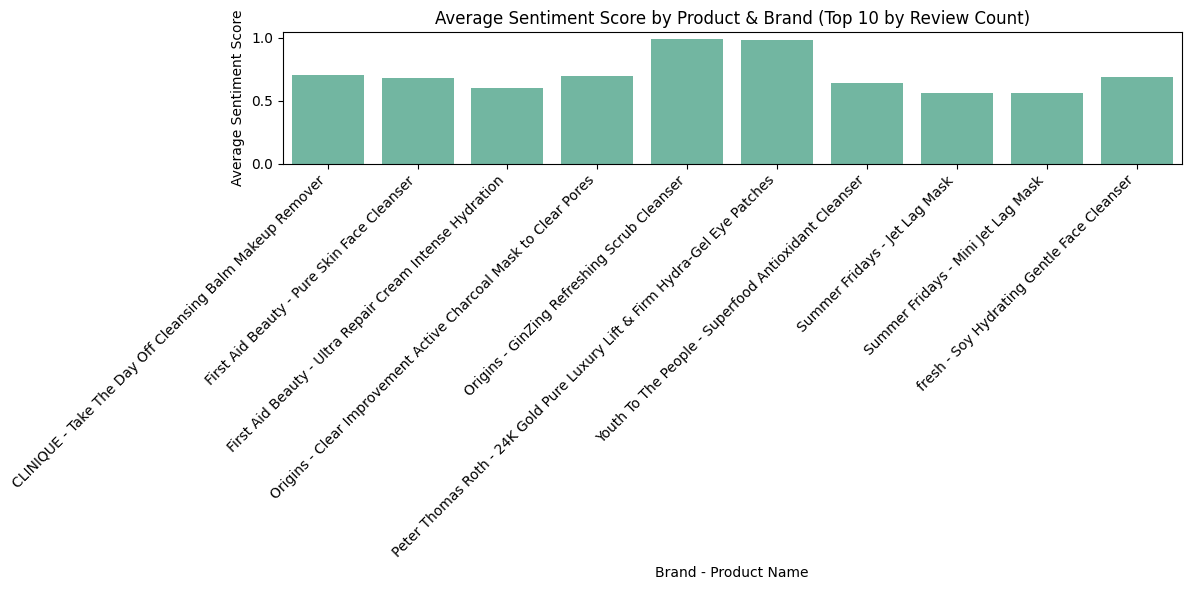

Top 10 Most Reviewed Products with Average Sentiment:
product_id                                           product_name          brand_name  sentiment_score
   P386197                      GinZing Refreshing Scrub Cleanser             Origins         0.993364
   P406104 24K Gold Pure Luxury Lift & Firm Hydra-Gel Eye Patches   Peter Thomas Roth         0.984498
   P126301         Take The Day Off Cleansing Balm Makeup Remover            CLINIQUE         0.703154
   P297524  Clear Improvement Active Charcoal Mask to Clear Pores             Origins         0.697525
     P7880                     Soy Hydrating Gentle Face Cleanser               fresh         0.691392
   P248404                                Pure Skin Face Cleanser    First Aid Beauty         0.678790
   P411387                         Superfood Antioxidant Cleanser Youth To The People         0.640689
   P248407                   Ultra Repair Cream Intense Hydration    First Aid Beauty         0.602756
   P429952         

In [159]:
# Average sentiment score by product

sentiment_map = {
    'label_0': -1,  # negative
    'label_1': 0,   # neutral
    'label_2': 1    # positive
}
df_reviews['sentiment_score'] = df_reviews['sentiment'].map(sentiment_map)

top_products = df_reviews['product_id'].value_counts().head(10).index
sentiment_avg = (
    df_reviews[df_reviews['product_id'].isin(top_products)]
    .groupby('product_id')['sentiment_score']
    .mean()
    .reset_index()
)

sentiment_avg = sentiment_avg.merge(
    df_reviews[['product_id', 'product_name', 'brand_name']].drop_duplicates(),
    on='product_id',
    how='left'
)

sentiment_avg['label'] = sentiment_avg['brand_name'] + " - " + sentiment_avg['product_name']

plt.figure(figsize=(12, 6))
sns.barplot(data=sentiment_avg, x='label', y='sentiment_score')
plt.xticks(rotation=45, ha='right')
plt.title('Average Sentiment Score by Product & Brand (Top 10 by Review Count)')
plt.ylabel('Average Sentiment Score')
plt.xlabel('Brand - Product Name')
plt.tight_layout()
plt.show()

sentiment_avg_sorted = sentiment_avg.sort_values(by='sentiment_score', ascending=False)
display_columns = ['product_id', 'product_name', 'brand_name', 'sentiment_score']
print("Top 10 Most Reviewed Products with Average Sentiment:")
print(sentiment_avg_sorted[display_columns].to_string(index=False))

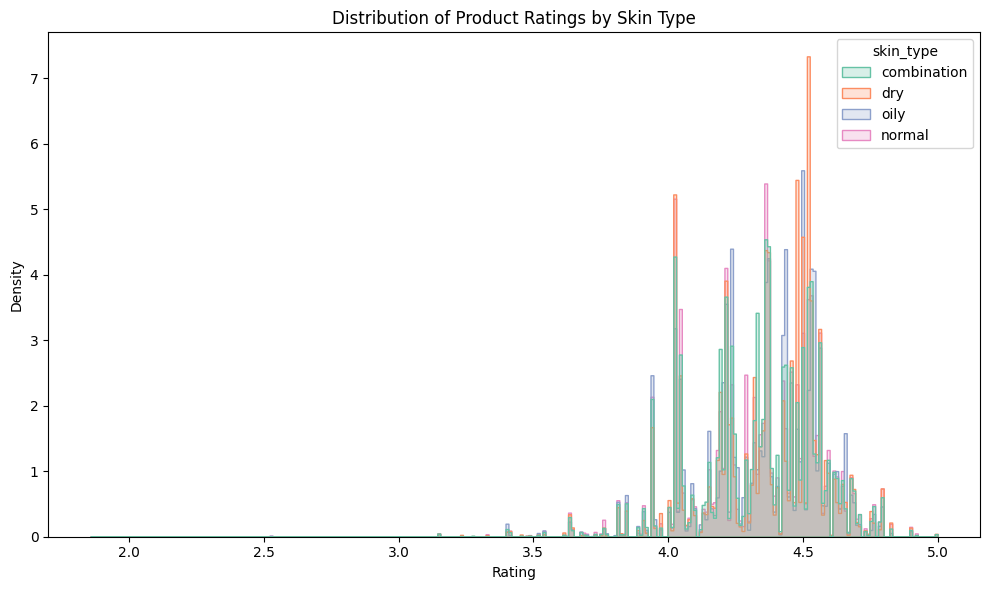

In [156]:
# Distribution of product ratings by skin types
sns.set_palette("Set2")
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(
    data=df_reviews,
    x='rating',
    hue='skin_type',
    element='step',
    stat='density',
    common_norm=False,
    ax=ax
)

ax.set_title('Distribution of Product Ratings by Skin Type')
ax.set_xlabel('Rating')
ax.set_ylabel('Density')
handles, labels = ax.get_legend_handles_labels()
plt.tight_layout()
plt.show()

     skin_type    rating
1          dry  4.353073
3         oily  4.345754
0  combination  4.337950
2       normal  4.334947


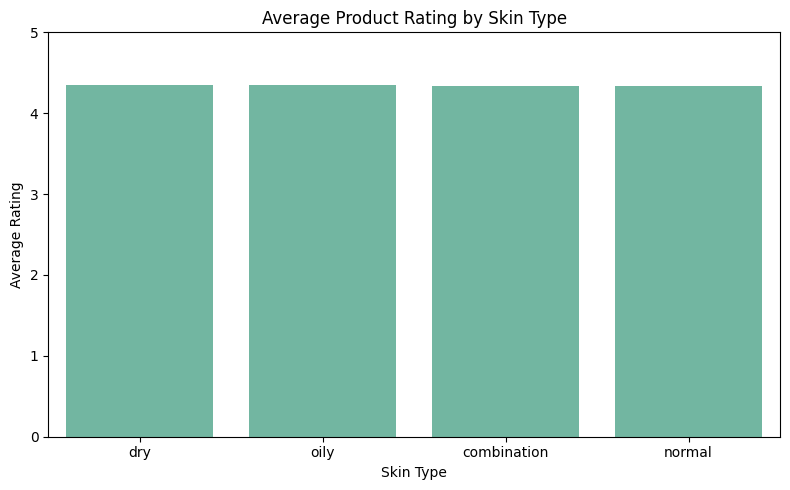

In [161]:
# Group by skin_type and calculate the average rating
avg_ratings_by_skin_type = (
    df_reviews[['skin_type', 'rating']]
    .dropna()
    .groupby('skin_type')
    .mean()
    .reset_index()
    .sort_values('rating', ascending=False)
)
print(avg_ratings_by_skin_type)

plt.figure(figsize=(8, 5))
sns.barplot(data=avg_ratings_by_skin_type, x='skin_type', y='rating')
plt.title('Average Product Rating by Skin Type')
plt.ylabel('Average Rating')
plt.xlabel('Skin Type')
plt.ylim(0, 5)
plt.tight_layout()
plt.show()

* Most skin types give similar product ratings

## Conclusion
This machine learning-based recommender system is tailored to help consumers navigate the crowded skincare product space, which can often feel tedious and overwhelming due to the abundance of information and contradicting opinions. By incorporating sentiment analysis, user preferences, and reviews, this model offers a robust pipeline that predicts both the likelihood of a product being recommended and its overall popularity. After a thorough prepreocessing and model testing, XGBoost came on top for recommendation classification while Ranom Forest for predicting popularity. the final recommendation score successfully integrates both prediction outputs to rank products most likely to satisfy user needs. The evaluation also showed high precisiion in the top recommendations, demonstrating that the system surfaces highly relevant products. This project offers a strong foundation for a personalized skincare discovery tool. For future recommendations, it could be further enhanced by integrating deeper NLP on product highlights and transitioning to a user-facing application.